# PhysioMTL

The code below attempts to reproduce work from the 2022 paper “PhysioMTL: Personalizing Physiological Patterns using Optimal Transport Multi-Task Regression” (Zhu et al. 2022) [1]. The paper outlines Physiological Multitask-Learning, or PhysioMTL, a proposed method for improving heart rate variability (HRV) interpretation developed by resources at Apple Machine Learning Resource, Carnegie Mellon University, University of Illinois Urbana-Champaign, and University of Michigan. HRV is used to measure cardiovascular health and detect acute illnesses, but is too sensitive to irrelevant factors such as hydration, sleep, stress, etc. (Acharya et al. 2006; European Society of Cardiology and Pacing Electrophysiology 1996) [2]. PhysioMTL attempts to denoise and normalize HRV data. Specifically, it learns to predict heart rate patterns at specific times of day based on demographics (age, gender, activity level, stress, etc).

What makes PhysioMTL interesting is that it utilizes multi-task learning (MTL), treating patients as tasks. It then uses Optimal Transport (OT) methods to efficiently match data to unseen patients and adjust for data gaps. Overall, this is an early use of multi-task learning in healthcare.

The specific claims of the original paper we are testing in this code are as follows:

* PhysioMTL trained on a large sample set (80% of MMASH) outperforms (RMSE) the 5 baseline methods above
* PhysioMTL trained on a very small data set (20% of MMASH) outperforms (RMSE) the 5 baseline methods above
* PhysioMTL holds a more stable (lesser range) accuracy than the 5 baseline methods above across many data set training size (20%, 40%, 60%, and 80% of MMASH)

Each claim will also be evaluated against the 5 baseline methods of Group Lasso, Multi-level Lasso, Dirty models, Multi-task Wasserstein, and Reweighted Multi-task Wasserstein.

The following code will automatically download, process, train, and test the MMASH dataset and report results that support the claims presented in the paper. The notebook will generate an HRV prediction for a person who is 40 with a BMI of 25, sleeps 7 hours per day, has an activity level of 1.5 hours per day, and a stress level of 40. This prediction is also modeled in the original paper.

# Requirements & Imports

This code is intended to be ran on `Python 3.9`.

Multi-task regression library MuTaR is utilized to compare PhysioMTL evaluation with various other methods, including the following:

* Group Lasso
* Multi-Level Lasso
* Dirty Model
* MT Wasserstein
* Reweighted MT Wasserstein
* PhysioMTL

Python Optimal Transport (POT) and HWCounter are used for reporting of computational requirements and comparison of efficiency among the compared methods. These external libraries, along with other standard Python libraries, are mentioned below with version requirements:

* Numpy (1.22.4)
* Pandas (1.5.3)
* Matplotlib (3.7.1)
* Pot (0.9.0)
* Scipy (1.10.1)

In [ ]:
!git clone https://github.com/hichamjanati/mutar
%cd mutar
!pip install -e .
%cd /content

%pip install pot
%pip install hwcounter

import site 
site.main()

Cloning into 'mutar'...
remote: Enumerating objects: 916, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 916 (delta 8), reused 16 (delta 7), pack-reused 899
Receiving objects: 100% (916/916), 1.72 MiB | 8.81 MiB/s, done.
Resolving deltas: 100% (495/495), done.
/content/mutar
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mutar
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mutar
/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.2/709.2 kB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for hwcounter: filename=hwcounter-0.1.1-cp39-cp39-linux_x86_64.whl size=16883 sha256=0d009c8915e0b3695

In [ ]:
# Evaluation of computational requirements, hardware logging, etc.
import platform
import socket
import re
import uuid
import json
import psutil
import logging

# Regression methods
import zipfile
import numpy as np
import pandas as pd
import ot
import matplotlib.cm as cm
import random
import mutar
from mutar import GroupLasso, DirtyModel, MTW, MultiLevelLasso, ReMTW
from hwcounter import Timer, count, count_end
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.utils import shuffle

## Identify System Resources

These method definitions are used in various downstream classes to calculate precise computational requirements of both PhysioMTL and comparable methods. System information is printed and should be evaluated when comparing your results with results reported in our paper, as varation in CPU/memory and runtime can introduce considerable differences in CPU utilization. System requirements used in the creation of our paper are as follows:

* Architecture: x86_64
* RAM: 13GB
* CPU Cores (Physical): 1
* CPU Cores (Logical): 2
* Platform: Linux



In [ ]:
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

def get_memory_utilization():
    svmem = psutil.virtual_memory()
    info = {}
    info['Total memory'] = f'{get_size(svmem.total)}'
    info['Available memory'] = f'{get_size(svmem.available)}'
    info['Used memory'] = f'{get_size(svmem.used)}'
    info['Memory utilization'] = f'{svmem.percent}%'
    return info

def get_system_info():
    cpufreq = psutil.cpu_freq()
    svmem = psutil.virtual_memory()
    info = {}
    info['platform'] = platform.system()
    info['platform-release'] = platform.release()
    info['platform-version'] = platform.version()
    info['architecture'] = platform.machine()
    info['hostname'] = socket.gethostname()
    info['ip-address'] = socket.gethostbyname(socket.gethostname())
    info['mac-address'] = ':'.join(re.findall('..', '%012x' % uuid.getnode()))
    info['processor'] = platform.processor()
    info['ram'] = str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
    info['physical cpu cores'] = psutil.cpu_count(logical=False)
    info['total cpu cores'] = psutil.cpu_count(logical=True)
    info = info | get_memory_utilization()
    return json.dumps(info)

def get_cpu_seconds(cycles):
    return cycles / psutil.cpu_count(logical=True) / 1000000000

json.loads(get_system_info())

{'platform': 'Linux',
 'platform-release': '5.10.147+',
 'platform-version': '#1 SMP Sat Dec 10 16:00:40 UTC 2022',
 'architecture': 'x86_64',
 'hostname': 'd6ce45fcab1c',
 'ip-address': '172.28.0.12',
 'mac-address': '02:42:ac:1c:00:0c',
 'processor': 'x86_64',
 'ram': '13 GB',
 'physical cpu cores': 1,
 'total cpu cores': 2,
 'Total memory': '12.68GB',
 'Available memory': '11.03GB',
 'Used memory': '1.37GB',
 'Memory utilization': '13.0%'}

# MMASH Data Set

The MMASH dataset contains 24-hour psycho-physiological data from 22 healthy adults. It includes data on respiratory rate, sleep quality, physical activity, anxiety, stress, and emotions Multilevel Monitoring of Activity and Sleep in Healthy People (MMASH) [3]

##Download MMASH

In [ ]:
!mkdir MMASH
!mkdir Data
!mkdir Data/figures
!wget -O MMASH/mmash.zip -r -N -c -np https://physionet.org/files/mmash/1.0.0/MMASH.zip

with zipfile.ZipFile('MMASH/mmash.zip', 'r') as zip_ref:
  zip_ref.extractall('MMASH')

!rm MMASH/mmash.zip

mkdir: cannot create directory ‘MMASH’: File exists
mkdir: cannot create directory ‘Data’: File exists
mkdir: cannot create directory ‘Data/figures’: File exists
will be placed in the single file you specified.

for details.

--2023-04-23 21:31:20--  https://physionet.org/files/mmash/1.0.0/MMASH.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24649620 (24M) [application/zip]
Saving to: ‘MMASH/mmash.zip’

MMASH/mmash.zip     100%[===================>]  23.51M  1.32MB/s    in 19s     

2023-04-23 21:31:39 (1.25 MB/s) - ‘MMASH/mmash.zip’ saved [24649620/24649620]

FINISHED --2023-04-23 21:31:39--
Total wall clock time: 19s
Downloaded: 1 files, 24M in 19s (1.25 MB/s)


##Preprocess MMASH

Preprocessing of the MMASH dataset is by converting respiratory rate to HRV in 5 minute intervals, omission of instances with a z-score over a threshold (2.5 by default). We also perform additional data cleansing to match behavior followed by the authors of the original paper, which included ignoring patient 4 (due to extreme HRV measurements) and populating missing sleep and age data on two other patients.

In [ ]:
# Scripting constants
BASELINE_DATES = {1: "2020-08-01", 2: "2020-08-02"}
RANDOM_STATE = 12345
USER_FILE_PREFIX = "/content/MMASH/DataPaper/user_"
TASKS = range(1, 23)

# Data set variables
RELEVANT_ACTIVITY = [4, 5]
USER_INFO_FIELDS = ["Age", "Height", "Weight"]
OMIT_TASKS = [4,]
OVERWRITES = {3: [5,60], 11: [4,6.5], 18: [0,22]}
RAD_HOUR = 2.0 * np.pi / 24

# Pre-processing hyperparameters
IBIS_UPPER = 2.1
IBIS_LOWER = 0.3
FREQUENCY = "5min"
NOISE_UPPER = 55.0
NOISE_SAMPLE_PERCENT = 0.85

In [ ]:
class MMASH:
    def __init__(self, tasks, max_zscore, max_noise=NOISE_UPPER):
        self.max_zscore = max_zscore
        if self.max_zscore is None:
            self.max_zscore = 999999
        self.max_noise = max_noise
        self.X, self.S, self.Y = [], [], []
        self.start_processing_cycles = count()

        for i in tasks:
            i_start = count()
            user_folder = USER_FILE_PREFIX + str(i)

            sleep_value = self.get_sleep_data(pd.read_csv(user_folder + "/sleep.csv"))
            activity_value = self.get_activity_data(pd.read_csv(user_folder + "/Activity.csv", header=0))
            user_info_value = self.get_user_info_data(pd.read_csv(user_folder + "/user_info.csv", header=0))
            questionnaire_value = self.get_questionnaire_data(pd.read_csv(user_folder + "/questionnaire.csv", header=0))
            rr_value = self.get_rr_data(pd.read_csv(user_folder + "/RR.csv", header=0))

            t_hour = rr_value["t_hour"].values
            s_vector = np.hstack([user_info_value, activity_value, sleep_value, questionnaire_value])
            if i in OVERWRITES:
                s_vector[OVERWRITES[i][0]] = OVERWRITES[i][1]
            
            self.X.append(np.asarray([np.sin(RAD_HOUR * t_hour), np.cos(RAD_HOUR * t_hour), np.ones(t_hour.shape[0], )]).T)
            self.S.append(s_vector.reshape(-1, 1))
            self.Y.append(rr_value["value"].values.reshape((-1, 1)))

            i_cycles = count_end() - i_start
            print(f'{i}: preprocessed task, y-mean = {rr_value["value"].mean()}, elapsed time: {i_cycles} cycles ({get_cpu_seconds(i_cycles)} seconds)')

        self.X = np.asarray(self.X)
        self.S = np.asarray(self.S)
        self.Y = np.asarray(self.Y)
        self.elapsed_processing_cycles = count_end() - self.start_processing_cycles
        print(f'finished processing mmash data set, elapsed cycles: {self.elapsed_processing_cycles} cycles ({get_cpu_seconds(self.elapsed_processing_cycles)} seconds)')

    def get_sleep_data(self, data):
        return data["Total Minutes in Bed"].sum() / 60

    def get_activity_data(self, data):
        data = data.copy().dropna()
        activity = lambda x: pd.to_timedelta(x["End"] + ":00") - pd.to_timedelta(x["Start"] + ":00")
        data["time_start_pd"] = data.apply(activity, axis=1)
        data["time_end_pd"] = data.apply(activity, axis=1)
        data["time_last_hour"] = data["time_end_pd"].apply(lambda x: x.seconds / 3600)
        data = data.loc[data["Activity"].isin(RELEVANT_ACTIVITY)]
        return data["time_last_hour"].sum() if not data.empty else 0

    def get_user_info_data(self, data):
        data = data[USER_INFO_FIELDS].loc[0].values
        return [data[0], data[1] / 100.0, data[2]]

    def get_questionnaire_data(self, data):
        return data["Daily_stress"].loc[0]

    def get_rr_data(self, data):
        data["new_time"] = data.apply(lambda ds: pd.to_datetime(BASELINE_DATES.get(ds["day"], BASELINE_DATES[2]) + " " + str(ds["time"])), axis=1)
        data['ibi_s'] = [x if x < IBIS_UPPER and x > IBIS_LOWER else np.nan for x in data['ibi_s']]
        data = [w for _, w in data.dropna().groupby(pd.Grouper(key='new_time', freq=FREQUENCY)) if not w.empty]
        rr_value = pd.DataFrame({
            "new_time": [x["new_time"].mean() for x in data],
            "value": [np.std(1000 * x["ibi_s"], ddof=1) for x in data]
        })
        no_noise = rr_value["value"] < self.max_noise
        no_noise = rr_value[no_noise].sample(int(NOISE_SAMPLE_PERCENT * no_noise.sum()), random_state=RANDOM_STATE)
        rr_value = rr_value.drop(no_noise.index)
        rr_value = rr_value.loc[np.abs(stats.zscore(rr_value["value"])) < self.max_zscore]
        rr_value = rr_value.loc[rr_value["value"] > 12]
        rr_value["t_hour"] = rr_value["new_time"].apply(lambda x: (x - pd.Timestamp(BASELINE_DATES[1] + " 00:00:00")).total_seconds() / 3600)
        return rr_value


In [ ]:
tasks = [i for i in TASKS if i not in OMIT_TASKS]
mmash = MMASH(tasks, max_zscore=2.5)

1: preprocessed task, y-mean = 85.56476822678721, elapsed time: 55554360457 cycles (27.7771802285 seconds)
2: preprocessed task, y-mean = 100.33561841324313, elapsed time: 15493788660 cycles (7.74689433 seconds)
3: preprocessed task, y-mean = 76.47079460368347, elapsed time: 21669234462 cycles (10.834617231 seconds)
5: preprocessed task, y-mean = 90.258288824083, elapsed time: 20522770471 cycles (10.2613852355 seconds)
6: preprocessed task, y-mean = 88.1846116338921, elapsed time: 20903521048 cycles (10.451760524 seconds)
7: preprocessed task, y-mean = 85.14250546385614, elapsed time: 21612997646 cycles (10.806498823 seconds)
8: preprocessed task, y-mean = 96.14583988348869, elapsed time: 18281737316 cycles (9.140868658 seconds)
9: preprocessed task, y-mean = 88.87771062928078, elapsed time: 18116740458 cycles (9.058370229 seconds)
10: preprocessed task, y-mean = 96.38566520289122, elapsed time: 16120833574 cycles (8.060416787 seconds)
11: preprocessed task, y-mean = 87.05496543244831,

<ipython-input-70-4219fbfe9ea6>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.X = np.asarray(self.X)
<ipython-input-70-4219fbfe9ea6>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.Y = np.asarray(self.Y)


# PhysioMTL Model Definition

The below PhysioMTL model is a multi-task learning model that treats every known patient as a task but does not follow a standard neural network pattern such as GNN or RNN. The algorithm learns a transformation matrix that maps the input features of each subject to a common feature space, and then learns a weight matrix that maps the common feature space to the output space of each subject. 

The goal is to minimize the distance between predictions and true outputs across all subjects. The parameters are as follows: 
* Input data (X) has 1 parameter per task for time. 
* Source tasks (S) have 6 parameters for sleep, activity, stress, age, height, and weight. 
* And target tasks (Y) have one parameter of HRV.

During the learning process for optimization/loss, the model first uses input data and target tasks to solve a weight matrix using linear regression. When it constructs cost and mapping matrices from source tasks, it uses weighted root mean squared error as a cost or objective function. Then it uses optimal transport (OT) to build a plan using the Sinkhorn algorithm, and a transformation matrix that maps demographic features to HRV. Using gradient descent, it alternates between optimizing the transformation matrix and OT plan until convergence. Once the transformation matrix is learned, the model can predict HRV data for new sets of demographic and time-of-day features.

In [ ]:
T_GRADIENT_THRESHOLD = 1e-8
W_GRADIENT_THRESHOLD = 1e-7
COST_FUNC = lambda x, y: np.sqrt(np.mean(np.square(np.dot([1, 10., 1., 10, 1., 1.], x - y))))

In [ ]:
class PhysioMTL:
    def __init__(self, cost_func, iterations=50, t_learn_rate=0.09, t_iterations=200, w_learn_rate=1e-7, w_iterations=50, alpha=0.1, epsilon=1e-4, lambda_=5, sigma=10, verbose=False):
        self.cost_func = cost_func
        self.iterations = iterations
        self.t_learn_rate = t_learn_rate
        self.t_iterations = t_iterations
        self.w_learn_rate = w_learn_rate
        self.w_iterations = w_iterations
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.sigma = sigma
        self.verbose = verbose

    def fit(self, X, S, Y):
        self.start_fit_cycles = count()
        self.S = S
        W = self.solve_w_by_linear_regression(X, Y)
        C, K = self.get_cost_matrix(S)
        Pi = self.solve_ot_plan(C)
        self.coef_ = self.W, self.T = self.converge_fw_gradient_descent(X, Y, W, K, Pi)
        self.end_fit_cycles = count_end() - self.start_fit_cycles 
        if self.verbose:
          print(f'PhysioMTL fit completed in {self.end_fit_cycles} cycles ({get_cpu_seconds(self.end_fit_cycles)} seconds)')

    def solve_w_by_linear_regression(self, X, Y):
        return np.concatenate([Y[i].T @ x @ np.linalg.inv(x.T @ x) for i, x in enumerate(X)]).T

    def get_cost_matrix(self, S):
        C = np.asarray([[self.cost_func(i, j) for j in S] for i in self.S])
        K = np.exp(-C / (2 * self.sigma**2))
        return C, K

    def solve_ot_plan(self, C):
        T = len(C)
        fracs = np.ones(T) / T
        transport_matrix = np.exp(-self.lambda_ * C)
        transport_matrix /= transport_matrix.sum()
        u = np.zeros(T)
        while np.max(np.abs(u - transport_matrix.sum(1))) > self.epsilon:
            u = transport_matrix.sum(1)
            transport_matrix *= fracs / u[:, None]
            transport_matrix *= fracs / transport_matrix.sum(0)[None, :]
        return transport_matrix

    def converge_fw_gradient_descent(self, X, Y, W, K, Pi):
        N = len(X)
        Z = np.zeros((W.shape[0], K.shape[0]))
        T = np.zeros((W.shape[0], K.shape[0]))
        for iteration in range(self.iterations):
            norm_last = 1e6
            for t in range(self.t_iterations):
                grad = [Pi[i, j] * (W[:, i:i+1] - T @ K[:, j:j+1]) @ K[:, j:j+1].T for i in range(N) for j in range(N)]
                grad = Z - self.alpha * 2 * sum(grad)
                norm = np.sum(np.square(grad))
                if np.abs(norm_last - norm) < T_GRADIENT_THRESHOLD:
                    break
                norm_last = norm
                T = T - self.t_learn_rate * grad
            #print(iteration, ": T gradient F-norm:", norm)

            norm_last = 1e6
            for w in range(self.w_iterations):
                grad = np.zeros_like(W)
                for t in range(N):
                    grad[:, t:t+1] = ((W[:, t:t+1].T @ X[t].T - Y[t].T) @ (X[t]) - self.alpha * sum([(T @ K[:, tt:tt+1] - W[:, tt:tt + 1]).T for tt in range(N)])).T
                norm = np.sum(np.square(grad))
                if np.abs(norm_last - norm) < W_GRADIENT_THRESHOLD:
                    break
                norm_last = norm
                W = W - self.w_learn_rate * grad
        return W, T

    def predict(self, X, S):
        self.start_predict_cycles = count()
        if X is None and S is None:
            return [x @ self.W[:, i:i+1] for i, x in enumerate(self.X)]

        _, K = self.get_cost_matrix(S)
        K = [K[:, i:i+1] for i in range(len(S))]
        self.end_predict_cycles = count_end() - self.start_predict_cycles
        if self.verbose:
            print(f'PhysioMTL predict completed in {self.end_predict_cycles} cycles ({get_cpu_seconds(self.end_predict_cycles)} seconds)')

        return [x @ self.T @ K[i] for i, x in enumerate(X)]

# Train the model

In [ ]:
model = PhysioMTL(COST_FUNC, verbose=True)
model.fit(mmash.X, mmash.S, mmash.Y)

PhysioMTL fit completed in 103521821465 cycles (51.7609107325 seconds)


# Sample PhysioMTL Prediction

Perform a sample prediction against the trained model, and plot the predicted HRV values.

PhysioMTL predict completed in 1081462 cycles (0.000540731 seconds)


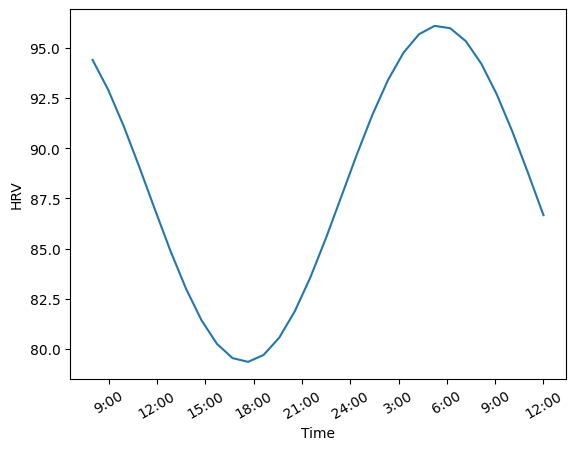

In [ ]:
S_ = np.array([23., 1.80, 85., 1., 7., 20.]).reshape(-1, 1)

T_ = np.linspace(8, 36, 30)
X_ = np.asarray([np.sin(RAD_HOUR * T_), np.cos(RAD_HOUR * T_), np.ones(30, )]).T

_, ax = plt.subplots()

ticks = [[9, '9:00'], [12, '12:00'], [15, '15:00'], [18, '18:00'], [21, '21:00'], [24, '24:00'], [27, '3:00'], [30, '6:00'], [33, '9:00'], [36, '12:00']]
ax.set_xticks([x[0] for x in ticks])
ax.set_xticklabels([x[1] for x in ticks], rotation=30)
ax.set_ylabel("HRV")
ax.set_xlabel("Time")

ax.plot(T_, model.predict([X_], [S_])[0])

# Model Performance

The following evaluation methods are used to both assess performance of our model and address various claims made by the authors of the original PhysioMTL paper.  

## Evaluation Methods

In [ ]:
def evaluate_all_percentages(X, S, Y, percentages, compare_alpha=0.9, physio_alpha=0.1, iterations=20, cost_func=COST_FUNC):
    for p in percentages:
        start_evaluation_time = count()
        evaluate_all(X, S, Y, p, compare_alpha, physio_alpha, iterations, cost_func)
        end_evaluation_time = count_end() - start_evaluation_time
        print('    Evaluation:')
        print(f'         iterations: {iterations}')
        print(f'         elapsed time: {end_evaluation_time} cycles ({get_cpu_seconds(end_evaluation_time)} seconds)')
        print('')

def evaluate_all(X, S, Y, percentage, compare_alpha, physio_alpha, iterations, cost_func):
    mse_physio = []
    mse_glasso = []
    mse_mlasso = []
    mse_dirty = []
    mse_mtw = []
    mse_remtw = []
    
    for _ in range(iterations):
        cutoff = int(percentage * len(S))
        idx = list(range(0, len(S)))
        random.shuffle(idx)
        train_index, test_index = idx[:cutoff], idx[cutoff:]
        X_train = [X[i] for i in train_index]
        S_train = [S[i] for i in train_index]
        Y_train = [Y[i] for i in train_index]
        X_test = [X[i] for i in test_index]
        S_test = [S[i] for i in test_index]
        Y_test = [Y[i] for i in test_index]
        
        if physio_alpha:
            model = PhysioMTL(cost_func, alpha=physio_alpha, verbose=False)
            model.fit(X_train, S_train, Y_train)
            preds = model.predict(X_test, S_test)
            mse_physio.append(get_rmse(preds, Y_test))

        x = np.zeros((len(X_train), 100, 3 + 6))
        y = np.zeros((len(X_train), 100))
        for i, s in enumerate(S_train):
            idx = list(range(0, X_train[i].shape[0]))
            random.shuffle(idx)
            x[i:i+1, :, 0:3] = X_train[i][idx[:100]]
            y[i:i+1, :] = Y_train[i][idx[:100]].reshape((1, -1))
            x[i:i+1, :, 3:] = s.reshape((1, -1))

        if compare_alpha:
            grouplasso_mse = get_mse(GroupLasso(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            mllasso_mse = get_mse(MultiLevelLasso(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            dirty_mse = get_mse(DirtyModel(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            mtw_mse = get_mse(MTW(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)
            remtw_mse = get_mse(ReMTW(alpha=compare_alpha), x, y, S_train, X_test, S_test, Y_test, cost_func)

            mse_glasso.append(grouplasso_mse)
            mse_mlasso.append(mllasso_mse)
            mse_dirty.append(dirty_mse)
            mse_mtw.append(mtw_mse)
            mse_remtw.append(remtw_mse)

    print(f'{percentage*100}% (alpha {compare_alpha} vs {physio_alpha})')
    if compare_alpha:
        print(f'    Group Lasso:  {np.mean(mse_glasso)} ± {np.std(mse_glasso)}')
        print(f'    MLevel Lasso: {np.mean(mse_mlasso)} ± {np.std(mse_mlasso)}')
        print(f'    Dirty Model:  {np.mean(mse_dirty)} ± {np.std(mse_dirty)}')
        print(f'    MT Was:       {np.mean(mse_mtw)} ± {np.std(mse_mtw)}')
        print(f'    MT Was Rewgt: {np.mean(mse_remtw)} ± {np.std(mse_remtw)}')
    if physio_alpha:
        print(f'    PhysioMTL:    {np.mean(mse_physio)} ± {np.std(mse_physio)}')

def get_rmse(a, b):
    return sum([np.sqrt(np.mean(np.square(a[i] - b[i]))) for i in range(len(a))]) / len(a)

def get_mse(model, X_train, Y_train, S_train, X_test, S_test, Y_test, cost_func):
    model.fit(X_train, Y_train)
    y = []
    for i, s_test in enumerate(S_test):
        idx = []
        for _, top_cost in sorted((cost_func(s, s_test), s) for s in S_train)[:1]:
            for j, s_train in enumerate(S_train):
                if np.max(s_train - top_cost) < 1e-6:
                    idx.append(j)
                    break

        X = np.zeros((len(X_test[i]), 9))
        X[:, 0:3] = X_test[i]
        X[:, 3:] = s_test.reshape((1, -1))
        y.append(X @ model.coef_[:, idx] + np.median(Y_train))

    return get_rmse(y, Y_test)

## Original Evaluation

Train the MMASH dataset using the author utilized alpha and Physio alpha values, among a variety of training ratios, using our PhysioMTL model as well as 5 other baseline models. Training across all models is done over 20 iterations.

In [ ]:
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8])

20.0% (alpha 0.9 vs 0.1)
    Group Lasso:  31.118553331833546 ± 1.5374157976939464
    MLevel Lasso: 31.232091615820785 ± 1.5518849959589036
    Dirty Model:  31.118035731020115 ± 1.5377730102655203
    MT Was:       30.835615254366616 ± 1.5550552855909592
    MT Was Rewgt: 30.85054859039489 ± 1.5531222597860326
    PhysioMTL:    30.438092917344143 ± 1.190826795718004
     evaluation:
         iterations: 20
         elapsed time: 132189270744 cycles (66.094635372 seconds)

40.0% (alpha 0.9 vs 0.1)
    Group Lasso:  31.379531221872565 ± 1.752130964969415
    MLevel Lasso: 31.47107073689988 ± 1.7272305570929807
    Dirty Model:  31.379544224489297 ± 1.752128204339294
    MT Was:       30.84338322104626 ± 1.911085284847452
    MT Was Rewgt: 30.861123146324815 ± 1.9066840449991214
    PhysioMTL:    30.306086239651922 ± 1.3284320014455626
     evaluation:
         iterations: 20
         elapsed time: 394966697756 cycles (197.483348878 seconds)

60.0% (alpha 0.9 vs 0.1)
    Group Lasso:  3

#Experiment & Ablation Evaluations

In each of the following sections, we attempt to recreate various claims made by authors of the original paper. 

## Experiment 1: Validate Optimal Alpha

When the original authors trained the 5 baseline models for evaluation against PhysioMTL, they used a fixed alpha=0.9 (learning rate) for those models and alpha=0.1 for PhysioMTL. They stated that 0.9 was the optimal value for those other models. 

The code within this section addresses this claim by evaluating all 5 models as well as PhysioMTL across 20 iterations, each with 20%, 40%, 60%, and 80% of the MMASH data, with 10 different alpha values (0.1 to 1.0). In another words, we evaluate all 5 models across 1,000 iterations using increasing amounts of sample data and learning rates.

### For Baseline Comparison Models

Perform experimental ablation for 5 baseline models (Group lasso, multi-level lasso, dirty model, multi-task wasserstein, and reweighted multi-taks wasserstein learning models). Note that alpha 0.9 is not evaluated here, as it was done so in the Original Evaluation section above.

In [ ]:
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.1, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.2, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.3, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.4, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.5, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.6, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.7, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=0.8, physio_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], compare_alpha=1.0, physio_alpha=None)

20.0% (alpha 0.1 vs None)
    Group Lasso:  31.445474250232554 ± 1.4322593900319147
    MLevel Lasso: 31.459896130962562 ± 1.436989153694227
    Dirty Model:  31.445474250232554 ± 1.4322593900319147
    MT Was:       31.3394926808708 ± 1.4052717968546986
    MT Was Rewgt: 31.369273569446666 ± 1.4121181725504153
    Evaluation:
         iterations: 20
         elapsed time: 24954370816 cycles (12.477185408 seconds)

40.0% (alpha 0.1 vs None)
    Group Lasso:  31.172510611143377 ± 1.9060687262812706
    MLevel Lasso: 31.192757110397736 ± 1.9089727120178068
    Dirty Model:  31.172510611143377 ± 1.9060687262812706
    MT Was:       30.99310052446692 ± 1.9093118392580488
    MT Was Rewgt: 31.044535590345994 ± 1.9079357839376048
    Evaluation:
         iterations: 20
         elapsed time: 32119769490 cycles (16.059884745 seconds)

60.0% (alpha 0.1 vs None)
    Group Lasso:  31.509820141553348 ± 2.060712580059727
    MLevel Lasso: 31.521833371987242 ± 2.062343287482376
    Dirty Model:  31

### For PhysioMTL model


In [ ]:
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.1, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.2, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.3, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.4, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.5, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.6, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.7, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.8, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=0.9, compare_alpha=None)
evaluate_all_percentages(mmash.X, mmash.S, mmash.Y, percentages=[0.2, 0.4, 0.6, 0.8], physio_alpha=1.0, compare_alpha=None)

20.0% (alpha None vs 0.1)
    PhysioMTL:    30.47789396564354 ± 1.1331374191650436
    Evaluation:
         iterations: 20
         elapsed time: 72044736875 cycles (36.0223684375 seconds)

40.0% (alpha None vs 0.1)
    PhysioMTL:    29.88909249132421 ± 1.062087554190208
    Evaluation:
         iterations: 20
         elapsed time: 295376421210 cycles (147.688210605 seconds)

60.0% (alpha None vs 0.1)
    PhysioMTL:    30.087577076606106 ± 1.4848149136574915
    Evaluation:
         iterations: 20
         elapsed time: 654695126746 cycles (327.347563373 seconds)

80.0% (alpha None vs 0.1)
    PhysioMTL:    29.19618576163012 ± 2.605031594875035
    Evaluation:
         iterations: 20
         elapsed time: 1189648391001 cycles (594.8241955005 seconds)

20.0% (alpha None vs 0.2)
    PhysioMTL:    30.384491944462326 ± 0.8264193873644538
    Evaluation:
         iterations: 20
         elapsed time: 82742686421 cycles (41.3713432105 seconds)

40.0% (alpha None vs 0.2)
    PhysioMTL:    3

## Experiment 2: Remove Denoising (Z-Score Max)

The original authors omitted HRV data more than 2.5 standard deviations from the mean, as part of denoising. Within this section, we assess this decision by training all models with 20%, 40%, 60%, and 80% of MMASH without this z-score denoising, to evaluate whether PhysioMTL still performs better.

In [ ]:
tasks = [i for i in TASKS if i not in OMIT_TASKS]
mmash_no_zmax = MMASH(tasks, max_zscore=None)
evaluate_all_percentages(mmash_no_zmax.X, mmash_no_zmax.S, mmash_no_zmax.Y, percentages=[0.2, 0.4, 0.6, 0.8])

1: preprocessed task, y-mean = 88.26816519823224, elapsed time: 22815480164 cycles (11.407740082 seconds)
2: preprocessed task, y-mean = 106.69894156700501, elapsed time: 16637941236 cycles (8.318970618 seconds)
3: preprocessed task, y-mean = 80.96268204844812, elapsed time: 21038047876 cycles (10.519023938 seconds)
5: preprocessed task, y-mean = 92.00805532648388, elapsed time: 20167615624 cycles (10.083807812 seconds)
6: preprocessed task, y-mean = 88.97660286749205, elapsed time: 22774419578 cycles (11.387209789 seconds)
7: preprocessed task, y-mean = 88.3269091075991, elapsed time: 19272016952 cycles (9.636008476 seconds)
8: preprocessed task, y-mean = 100.73382907743859, elapsed time: 18441716556 cycles (9.220858278 seconds)
9: preprocessed task, y-mean = 92.15906246013618, elapsed time: 19997981440 cycles (9.99899072 seconds)
10: preprocessed task, y-mean = 99.96435977308549, elapsed time: 14900327814 cycles (7.450163907 seconds)
11: preprocessed task, y-mean = 88.99775811937653,

<ipython-input-6-4219fbfe9ea6>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.X = np.asarray(self.X)
<ipython-input-6-4219fbfe9ea6>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.Y = np.asarray(self.Y)


20.0% (alpha 0.9 vs 0.1)
    Group Lasso:  38.80242612503791 ± 1.7259633212877377
    MLevel Lasso: 38.958107424142646 ± 1.7390509008734039
    Dirty Model:  38.79935033179922 ± 1.7249275024236412
    MT Was:       38.200572159377835 ± 1.7511817026609549
    MT Was Rewgt: 38.22676921650946 ± 1.7466706006101098
    PhysioMTL:    37.437659114093606 ± 1.4160552312714056
    Evaluation:
         iterations: 20
         elapsed time: 126001571474 cycles (63.000785737 seconds)

40.0% (alpha 0.9 vs 0.1)
    Group Lasso:  38.973580183522195 ± 1.9173611196848108
    MLevel Lasso: 39.09850129696329 ± 1.910723045892831
    Dirty Model:  38.97009015963137 ± 1.9227466953028658
    MT Was:       38.3691328425458 ± 2.0446787674289713
    MT Was Rewgt: 38.39894634139346 ± 2.0395765702056323
    PhysioMTL:    36.727486474106705 ± 1.5461343301250392
    Evaluation:
         iterations: 20
         elapsed time: 391430116098 cycles (195.715058049 seconds)

60.0% (alpha 0.9 vs 0.1)
    Group Lasso:  38.42

## Experiment 3: Omit Unclean Sample Data

According to the original paper, the MMASH data set had some patients who were missing sleep and age data, so the authors coded assumed sleep and age numbers into the preprocessing. Doing this potentially risks confirming the authors’ biases that demographic data has very strong correlation to HRV, especially since MMASH is a relatively small data set. Thus, the code in this section performs an experiment in which we evaluate all models across 20%, 40%, 60%, and 80% of the MMASH data by excluding those patients, to see whether PhysioMTL still performs better.

In [ ]:
tasks = [i for i in TASKS if i not in OMIT_TASKS and i not in OVERWRITES]
mmash_no_unclean = MMASH(tasks, max_zscore=2.5)
evaluate_all_percentages(mmash_no_unclean.X, mmash_no_unclean.S, mmash_no_unclean.Y, percentages=[0.2, 0.4, 0.6, 0.8])

1: preprocessed task, y-mean = 85.56476822678721, elapsed time: 22966699884 cycles (11.483349942 seconds)
2: preprocessed task, y-mean = 100.33561841324313, elapsed time: 16870561298 cycles (8.435280649 seconds)
5: preprocessed task, y-mean = 90.258288824083, elapsed time: 19692808852 cycles (9.846404426 seconds)
6: preprocessed task, y-mean = 88.1846116338921, elapsed time: 24144136316 cycles (12.072068158 seconds)
7: preprocessed task, y-mean = 85.14250546385614, elapsed time: 19065019272 cycles (9.532509636 seconds)
8: preprocessed task, y-mean = 96.14583988348869, elapsed time: 18529598136 cycles (9.264799068 seconds)
9: preprocessed task, y-mean = 88.87771062928078, elapsed time: 19274104230 cycles (9.637052115 seconds)
10: preprocessed task, y-mean = 96.38566520289122, elapsed time: 17614707870 cycles (8.807353935 seconds)
12: preprocessed task, y-mean = 71.64783622577323, elapsed time: 20227822632 cycles (10.113911316 seconds)
13: preprocessed task, y-mean = 75.48997318086856, e

<ipython-input-6-4219fbfe9ea6>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.X = np.asarray(self.X)
<ipython-input-6-4219fbfe9ea6>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.Y = np.asarray(self.Y)


20.0% (alpha 0.9 vs 0.1)
    Group Lasso:  31.762716674421434 ± 1.2363972323758932
    MLevel Lasso: 31.917254311679706 ± 1.233244988177219
    Dirty Model:  31.761380904698235 ± 1.236580604053625
    MT Was:       31.241862294044427 ± 1.4242478418963838
    MT Was Rewgt: 31.262920363964703 ± 1.4186370722254964
    PhysioMTL:    31.112022710149596 ± 1.166067283489888
    Evaluation:
         iterations: 20
         elapsed time: 84281808584 cycles (42.140904292 seconds)

40.0% (alpha 0.9 vs 0.1)
    Group Lasso:  30.817187660763306 ± 1.6226938100974646
    MLevel Lasso: 30.93329365637772 ± 1.653810167774688
    Dirty Model:  30.81718921809812 ± 1.6226952394267906
    MT Was:       30.41447545348898 ± 1.6143065087358204
    MT Was Rewgt: 30.429188310445813 ± 1.616856098343266
    PhysioMTL:    30.082239870532835 ± 1.395199907752263
    Evaluation:
         iterations: 20
         elapsed time: 311565565672 cycles (155.782782836 seconds)

60.0% (alpha 0.9 vs 0.1)
    Group Lasso:  31.343

# References

[1] Zhu, Jiacheng et al. (July 2022). “PhysioMTL: Personalizing Physiological Patterns using Optimal Transport Multi-Task Regression”. In: Proceedings of the Conference on Health, Inference, and Learning. Ed. by Gerardo Flores et al. Vol. 174. Proceedings of Machine Learning Research. PMLR, pp. 354–374. URL: https://proceedings.mlr.press/v174/zhu22a.html.

[2] Acharya, Rajendra U. et al. (2006). “Heart Rate Variability: A Review”. In: Medical and Biological Engineering and Computing 44.12, pp. 1031–1051.

[3] Rossi, Alessio et al. (2020). Multilevel Monitoring of Activity and Sleep in Healthy People (MMASH). version 1.0.0. URL: https://doi.org/10.13026/cerq-fc86.
